# Required python packages

In [2]:
!pip install cbor
!pip install trec-car-tools
!pip install sentence_transformers

You should consider upgrading via the 'C:\Users\phamb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\phamb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


  Using cached tensorflow-2.3.1-cp37-cp37m-win_amd64.whl (342.5 MB)


ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: 'C:\\Users\\phamb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python37\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'

You should consider upgrading via the 'C:\Users\phamb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\phamb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\phamb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# Import


In [2]:
import elasticsearch

from elasticsearch import Elasticsearch, helpers
from tqdm import tqdm
from trec_car.read_data import *

import re
import numpy as np
import math
import json
import pandas as pd
import os
import random
import requests
from collections import Counter
from collections import defaultdict

from sentence_transformers import SentenceTransformer, util

from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor

# Initiation

In [3]:
# Init Elasticsearch
es = Elasticsearch()
# Init sentence to BERT vector transformer
st = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

## Setting

In [24]:
TRECCAR_FILE = '../dedup.articles-paragraphs.cbor'
MARCO_FILE = '../collection.tsv'
MARCO_DUP_FILE = '../duplicate_list_v1.0.txt'
INDEX = 'trec_index'
FIELD = ['body']
BULK_LEN = 5000

INDEX_SETTINGS = {
    'mappings': {
            'properties': {
                'body': {
                    'type': 'text',
                    'term_vector': 'yes',
                    'analyzer': 'english'
                }
            }
        }
    }

## Create Elasticsearch

In [4]:
if es.indices.exists(INDEX):
    es.indices.delete(INDEX)
    
es.indices.create(index=INDEX, body=INDEX_SETTINGS)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'trec_index'}

## Functions for indexing

In [5]:
def add_to_bulk(bulk_data, doc, doc_id):
    data = {
        "_index": INDEX,
        "_id": doc_id,
        "body": doc
    }
    bulk_data.append(data)
    return bulk_data

def start_bulk(es, bulk_data):
    helpers.bulk(es, bulk_data)


## Load Files & Indexing
<br>

### TREC CAR paragraphs

In [6]:
with open(TRECCAR_FILE, 'rb') as datafile:
    c = 0
    e = 0
    bulk_data = []
    for p in tqdm(iter_paragraphs(datafile), desc="Indexing TREC CAR", position=0, leave=True):
        try:
            # PARAGRAPH ID
            doc_id = "CAR_" + p.para_id
            
            # PARAGRAPH TEXT
            texts = [elem.text if isinstance(elem, ParaText)
                     else elem.anchor_text
                     for elem in p.bodies]
            doc = ' '.join(texts)
            
            c +=1 
            add_to_bulk(bulk_data, doc, doc_id)
            if len(bulk_data) >= BULK_LEN:
                start_bulk(es, bulk_data)
                bulk_data = []

        except Exception as E:
            e +=1

    if len(bulk_data) > 0:
        start_bulk(es, bulk_data)

print('Indexed total {} docs'.format(c))
print('With {} errors'.format(e))

Indexing TREC CAR: 29794697it [2:14:20, 3696.43it/s]


Indexed total 29794697 docs
With 0 errors


### MS MARCO collection
<br>

#### Load duplication file

In [7]:
dup_dict = {}
duplines = open(MARCO_DUP_FILE).readlines()
for line in duplines:
    data = line.strip().split(':')
    if len(data[1]) > 0:
        dups = data[-1].split(',')
        for dup in dups:
            dup_dict[dup] = 1

#### Index MARCO

In [8]:
with open(MARCO_FILE, 'r', encoding="utf-8") as datafile:
    c = 0
    e = 0
    bulk_data = []
    for line in tqdm(datafile, desc="Indexing MS MARCO", position=0, leave=True):
        
        try:
            # ID & TEXT
            doc_id, doc = line.strip().split('\t', 1)
            doc_id = 'MARCO_' + doc_id
            
            if doc_id in dup_dict:
                continue
            
            c +=1 
            add_to_bulk(bulk_data, doc, doc_id)
            if len(bulk_data) >= BULK_LEN:
                start_bulk(es, bulk_data)
                bulk_data = []
            
        except Exception as E:
            e +=1
            
    if len(bulk_data) > 0:
        start_bulk(es, bulk_data)
        
print('Indexed total {} docs'.format(c))
print('With {} errors'.format(e))

Indexing MS MARCO: 8841823it [25:37, 5750.06it/s]

Indexed total 8635155 docs
With 0 errors


## Queries - QREL

### File paths

In [4]:
txt=r'treccastweb\2019\data\training\train_topics_v1.0.txt'
qrel=r'treccastweb\2019\data\training\train_topics_mod.qrel'
test_doc=r'treccastweb\2020\2020_manual_evaluation_topics_v1.0.json'

### Load evaluation queries and the ground truths

In [5]:
def make_test(filepath):
    q_id=0
    queries = {}
    qrels = {}

    with open(filepath) as f:
        for data in json.load(f):
            for quer in (data['turn']):
                q_id=(str(data['number'])+'_'+str(quer['number']))
                queries[q_id]=(quer['raw_utterance'])
                for k,v in quer.items():
                    if 'canonical_result_id' in k:
                        qrels[q_id]=v

    return (qrels, queries)

### Extract Training Queries

In [6]:
def load_queries(filepath):
    queries = {}
    
    query_ID=''
    doc_num=0      
    with open( filepath ,"r") as fin:
        for line in fin.readlines():
            sp_line=line.split(':')
            if sp_line[0] =='Number':                
                doc_num=sp_line[1].strip()               
            
            check_dig=line[0:2].strip()
            if check_dig.isdigit() :
                    query_ID=doc_num+'_'+check_dig                    
                    queries[query_ID]=line.replace(line[0:2],'').strip()
    return queries

### Extract Training QRELs

In [7]:
def load_qrels(filepath):
    qrels = defaultdict(list)
        
    with open( filepath ,"rt", encoding='latin-1') as fin:
        for line in fin.readlines():
            line_split=line.split(' ') 
            qrels[line_split[0]].append(line_split[2])

    return qrels

# Learning-to-rank model
<br>

## Load files for Learning-to-rank model

### Helping functions

In [8]:
def analyze_query(es, query, field='body', index='trec_index'):
    tokens = es.indices.analyze(index=index, body={'text': query})['tokens']
    query_terms = []
    for t in sorted(tokens, key=lambda x: x['position']):
        hits = es.search(index=index, body={'query': {'match': {field: t['token']}}}, 
                                   _source=False, size=1).get('hits', {}).get('hits', {})
        doc_id = hits[0]['_id'] if len(hits) > 0 else None
        if doc_id is None:
            continue
        query_terms.append(t['token'])
    return query_terms

def get_doc_term_freqs(es, doc_id, field='body', index='trec_index'):
    tv = es.termvectors(index=index, id=doc_id, fields=field, term_statistics=True)
    if tv['_id'] != doc_id:
        return None
    if field not in tv['term_vectors']:
        return None
    term_freqs = {}
    for term, term_stat in tv['term_vectors'][field]['terms'].items():
        term_freqs[term] = term_stat['term_freq']
    return term_freqs
        
def get_query_term_freqs(es, query_terms):
    c = Counter()
    for term in query_terms:
        c[term] += 1
    return dict(c)

### Extract Query Features

In [9]:
def extract_query_features(query_terms, es, index='trec_index'):
    q_features = {}
    q_features['query_length']=(len(query_terms))
        
    idf=[]
    es.indices.refresh(index)
    N=(es.count(index=index)['count'])
    for q in query_terms:
        n=(es.count(index=index,q='body:'+q)['count'])
        try:
            idf.append(math.log(N/n))
        except ZeroDivisionError:
            idf.append(0) 
            
    q_features["query_sum_idf"] = sum(idf) if len(idf) > 0 else 0
    q_features["query_max_idf"] = max(idf) if len(idf) > 0 else 0
    q_features["query_avg_idf"] = q_features["query_sum_idf"] / len(idf) if len(idf) > 0 else 0
        
    return q_features

### Extract document features

In [10]:
def extract_doc_features(doc_id, es, index='trec_index'):
    doc_features = {}

    termvectors = es.termvectors(index=index, id=doc_id, fields="body")["term_vectors"]
    if termvectors:
        val = 0
        for key, value in termvectors['body']["terms"].items():
            val += value["term_freq"]
        doc_features["doc_length"] = val

    return doc_features

### Extract Query-Document features

In [11]:
def extract_query_doc_features(query_terms, doc_id, es, index='trec_index'):
    q_doc_features = {}

    b=[]
    tf_bod = []
    
    for q in query_terms:
        q_t={}
        dtf=get_doc_term_freqs(es, doc_id, 'body', index=index)
        if dtf and q in dtf:
            b.append(q)
            tf_bod.append(dtf[q])
        else:
            tf_bod.append(0)

    q_doc_features['sum_TF_body']=sum(tf_bod) if len(tf_bod) > 0 else 0
    q_doc_features['max_TF_body']=max(tf_bod) if len(tf_bod) > 0 else 0
    q_doc_features['avg_TF_body']=np.mean(tf_bod) if len(tf_bod) > 0 else 0

    q_doc_features['unique_query_terms_in_body'] = len(set(b)) if len(b) > 0 else 0

    return q_doc_features

### Extract and combine all features

In [12]:
FEATURES_QUERY = ['query_length', 'query_sum_idf', 'query_max_idf', 'query_avg_idf']
FEATURES_DOC = ['doc_length']
FEATURES_QUERY_DOC = ['unique_query_terms_in_body', 'sum_TF_body', 'max_TF_body', 'avg_TF_body']

def extract_features(query_terms, doc_id, es, index='trec_index'):
    feature_vect = []
    
    query_features = extract_query_features(query_terms, es, index=index)
    for f in FEATURES_QUERY:
        feature_vect.append(query_features[f])
    
    doc_features = extract_doc_features(doc_id, es, index=index)
    for f in FEATURES_DOC:
        feature_vect.append(doc_features[f])

    query_doc_features = extract_query_doc_features(query_terms, doc_id, es, index=index)
    for f in FEATURES_QUERY_DOC:
        feature_vect.append(query_doc_features[f])

    return feature_vect

### Preparing training data

In [13]:
def prepare_ltr_training_data(query_ids, es, index='trec_index'):
    X = []
    y = []

    for qid in query_ids:
        query = TREC_QUERIES[qid]
        q = analyze_query(es, query, "body", index=index)
        for doc_id in TREC_QRELS[qid]:
            if (es.termvectors(index=INDEX, id=doc_id)['found']) != False:
                X.append(extract_features(q, doc_id, es, index=index))
                y.append(1)
            else:
                continue
        search = es.search(index=index, q=" ".join(q), _source=True, size=100)["hits"]["hits"]
        for det in search:
            doc_id = det["_id"]
            if doc_id in TREC_QRELS[qid]: continue
            X.append(extract_features(q, doc_id, es, index=index))
            y.append(0)
    
    return X, y

### Model class

In [14]:
class PointWiseLTRModel(object):
    def __init__(self, regressor):
        self.regressor = regressor

    def _train(self, X, y):
        assert self.regressor is not None
        self.model = self.regressor.fit(X, y)

    def rank(self, ft, doc_ids):
        assert self.model is not None
        rel_labels = self.model.predict(ft)
        sort_indices = np.argsort(rel_labels)[::-1]

        results = []
        for i in sort_indices:
            results.append((doc_ids[i], rel_labels[i]))
        return results

### Generate the rankings of documents

In [15]:
def get_rankings(ltr, query_ids, es, index='trec_index', rerank=False):
    test_rankings = {}
    for i, query_id in enumerate(query_ids):
        query_terms = analyze_query(es, TEST_QUERIES[query_id], 'body', index=index)
        if len(query_terms) == 0:
            continue
        hits = es.search(index=index, q=' '.join(query_terms), _source=True, size=100)['hits']['hits']        
        test_rankings[query_id] = [hit['_id'] for hit in hits]
        
        feat={}
        if rerank:
            for doc_id in (test_rankings[query_id]):
                feat[doc_id]=(extract_features(query_terms, doc_id, es, index=index))
            rel=(ltr.rank(list(feat.values()), list(feat.keys())))
            ranks=sorted(rel, key = lambda x: x[1], reverse=True)
            test_rankings[query_id]=[k for k,v in ranks]
    return test_rankings

# BERT
<br>

## Combine with to learning-to-rank

In [46]:
def BERT_vector(query):
    return st.encode([query])[0]

def prepare_BERT_training_data(query_ids, es, index='trec_index'):

    X = []
    y = []

    for qid in query_ids:
        query = TREC_QUERIES[qid]
        q = analyze_query(es, query, "body", index=index)
        for doc_id in TREC_QRELS[qid]:
            if (es.termvectors(index=INDEX, id=doc_id)['found']) != False:
                doc = es.get(index, doc_id, source=True)['_source']['body']
                X.append(BERT_vector(doc))
                y.append(1)
            else:
                continue
        search = es.search(index=index, q=" ".join(q), _source=True, size=100)["hits"]["hits"]
        for det in search:
            doc_id = det["_id"]
            if doc_id in TREC_QRELS[qid]: continue
            X.append(BERT_vector(det['_source']['body']))
            y.append(0)
    
    return X, y

def BERT_rankings(ltr, query_ids, es, index='trec_index'):
    test_rankings = {}
    for i, query_id in enumerate(query_ids):
        query_terms = analyze_query(es, TEST_QUERIES[query_id], 'body', index=index)
        if len(query_terms) == 0:
            continue
        hits = es.search(index=index, q=' '.join(query_terms), _source=True, size=100)['hits']['hits']        
        test_rankings[query_id] = []
        docs = {}
        for hit in hits:
            test_rankings[query_id].append(hit['_id'])
            docs[hit['_id']] = (hit['_source']['body'])
        
        feat={}
        for doc_id in (test_rankings[query_id]):
            feat[doc_id]=(BERT_vector(docs[doc_id]))
        rel=(ltr.rank(list(feat.values()), list(feat.keys())))
        ranks=sorted(rel, key = lambda x: x[1], reverse=True)
        test_rankings[query_id]=[k for k,v in ranks]
    return test_rankings

## BERT with cosine similarity

In [40]:
def cossim_BERT_ranking(query_ids, es, index='trec_index'):
    test_rankings = {}
    for i, query_id in enumerate(query_ids):
        query_terms = analyze_query(es, TEST_QUERIES[query_id], 'body', index=index)
        if len(query_terms) == 0:
            continue
        query_vec = BERT_vector(' '.join(query_terms))
        hits = es.search(index=index, q=' '.join(query_terms), _source=True, size=100)['hits']['hits']        
        
        rel = []
        test_rankings[query_id] = []
        for hit in hits:
            test_rankings[query_id].append(hit['_id'])
            doc_BERT = BERT_vector(hit['_source']['body'])
            cos_scores = util.pytorch_cos_sim(query_vec, doc_BERT)
            rel.append((hit['_id'], cos_scores[0][0].item()))
        
        ranks=sorted(rel, key = lambda x: x[1], reverse=True)
        test_rankings[query_id]=[k for k,v in ranks]
    return test_rankings

# Evaluation functions

In [43]:
def get_reciprocal_rank(system_ranking, ground_truth):
    for i, doc_id in enumerate(system_ranking):
        if doc_id in ground_truth:
            return 1 / (i + 1)
    return 0
    
def get_mean_eval_measure(system_rankings, ground_truth, eval_function):

    sum_score = 0
    for query_id, system_ranking in system_rankings.items():
        sum_score += eval_function(system_ranking, ground_truth[query_id])
    return sum_score / len(system_rankings)

ERROR! Session/line number was not unique in database. History logging moved to new session 184


# Make Queries variables

In [19]:
# Get training Queries and QRELs
TREC_QRELS=load_qrels(qrel)
TREC_QUERIES=load_queries(txt)

# Get testing Queries and QRELs
TEST_QRELS, TEST_QUERIES = make_test(test_doc)

random.seed(a=1234567)
trec_query_ids = sorted(list(TREC_QUERIES.keys()))
random.shuffle(trec_query_ids)
TRAIN_QUERY_IDS = trec_query_ids
TEST_QUERY_IDS = TEST_QUERIES

# Training Retreival model
<br>

## BM25 

In [ ]:
rankings_BM25 = get_rankings(None, test_query_ids, es, index=INDEX, rerank=False)
mrr_BM25 = get_mean_eval_measure(rankings_BM25, TEST_QRELS, get_reciprocal_rank)

## Learning-to-rank using normal feature extraction
<br>

### Prepare the training sets

In [ ]:
X_train, y_train = prepare_ltr_training_data(TRAIN_QUERY_IDS, es, index=INDEX)

### Random Forest Regressor

In [ ]:
clf1 = RandomForestRegressor(max_depth=15, random_state=0, n_estimators=10)
ltr1 = PointWiseLTRModel(clf1)
ltr1._train(X_train, y_train)
rankings_ltr1 = get_rankings(ltr1, test_query_ids, es, index=INDEX, rerank=True)
mrr_ltr1 = get_mean_eval_measure(rankings_ltr1, TEST_QRELS, get_reciprocal_rank)

### MLP Regressor

In [ ]:
clf2 = MLPRegressor(random_state=0, max_iter=1500)
ltr2 = PointWiseLTRModel(clf2)
ltr2._train(X_train, y_train)
rankings_ltr2 = get_rankings(ltr2, test_query_ids, es, index=INDEX, rerank=True)
mrr_ltr2 = get_mean_eval_measure(rankings_ltr2, TEST_QRELS, get_reciprocal_rank)

### Gradient Boosting Classifier

In [ ]:
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=0)
ltr3 = PointWiseLTRModel(clf3)
ltr3._train(X_train, y_train)
rankings_ltr3 = get_rankings(ltr3, test_query_ids, es, index=INDEX, rerank=True)
mrr_ltr3 = get_mean_eval_measure(rankings_ltr3, TEST_QRELS, get_reciprocal_rank)

## Learning-to-rank using BERT

In [ ]:
X_train, y_train = prepare_BERT_training_data(TRAIN_QUERY_IDS, es, index=INDEX)

clfb = MLPRegressor(max_depth=5, random_state=0, n_estimators=10)
ltrb = PointWiseLTRModel(clfb)
ltrb._train(X_train, y_train)
rankings_ltr_Bert = BERT_rankings(ltrb, TEST_QUERY_IDS, es, index=INDEX)
mrr_ltr_Bert = get_mean_eval_measure(rankings_ltr_Bert, TEST_QRELS, get_reciprocal_rank)

## BERT with cosine similarity

In [41]:
ranking_BERT = cossim_BERT_ranking(TEST_QUERY_IDS, es, index=INDEX)
mrr_BERT = get_mean_eval_measure(ranking_BERT, TEST_QRELS, get_reciprocal_rank)

# The results

In [ ]:
models=['First-pass(BM25)','RandomForestRegressor','MLPRegressor','GradientBoostingClassifier', 'BERT']
pd.DataFrame([mrr_first_pass,mrr_ltr1,mrr_ltr2,mrr_ltr3, mmr_BERT],index=models,columns=['MRR Score'])

ERROR! Session/line number was not unique in database. History logging moved to new session 188


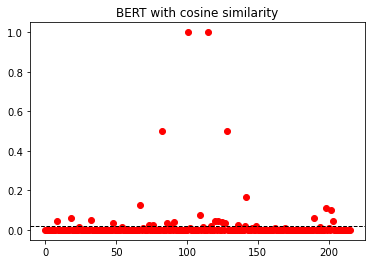

In [47]:
import matplotlib.pyplot as plot
def get_plot_data(system_rankings, ground_truth, eval_function):
    s=0
    data = []
    for query_id, system_ranking in system_rankings.items():
        rr = eval_function(system_ranking, ground_truth[query_id])
        if rr > 0:
            s += 1
        data.append(rr)
    return data

BERT_plot = get_plot_data(ranking_BERT, TEST_QRELS, get_reciprocal_rank)

plot.plot(BERT_plot, 'ro')
plot.axhline(mrr_BERT, color='k', linestyle='dashed', linewidth=1)
plot.title('BERT with cosine similarity')
plot.show()